# Seismic data cleaning

Seismic survey data in [Queensland](https://data.gov.au/data/dataset/873c76be-8b75-4c87-97cc-4e573ccefc63) is downloaded and cleaned (i.e. seismic lines aggregated into survey entries). Seismic line orientations are calculated and used to infer the intended survey dimension (2D or 3D) in order to calculate the historical probability of survey dimension for each year there is data available. Data are clipped to a specific [area of interest](https://data.gov.au/data/dataset/dad93b9e-c5b0-4f70-9f65-a821e06fc856).

**Aim: Infer and calculate historical probability of seismic survey dimension (2D or 3D) by year**

In [1]:
import requests
import zipfile
import math
import os
import fnmatch

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

In [2]:
# Download urls for two files from data.gov.au
gisfiles = [{'name':'aoi','url':'https://s3.ap-southeast-2.amazonaws.com/gba.dmp/datasets/DAD93B9E-C5B0-4F70-9F65-A821E06FC856/DAD93B9E-C5B0-4F70-9F65-A821E06FC856.zip'},
            {'name':'seismic', 'url':'https://datagovau.s3.amazonaws.com/bioregionalassessments/BA_ALL/ALL/DATA/Geology/Geophysics/SeismicQLD_DNRM_Seismic_survey_2D_-_Queensland/fc3ecd06-6725-498a-98b4-8f46dc05274a.zip'}]


## Download data via url
Download the seismic and AOI zip files using listed urls, extract the contents, and delete the zip files. This may take a few minutes depending on the internet connection.

In [3]:
for item in gisfiles:
    # get url of file
    response = requests.get(item['url'])
    
    filename = item['name']+'.zip'

    # download zip file
    with open(filename, "wb") as zfile:
        zfile.write(response.content)
    
    # unzip file
    with zipfile.ZipFile(filename, 'r') as unzip:
        unzip.extractall()
    
    # delete zip file
    os.remove(filename)


## Functions

Two functions needed to explore the orientations of seismic line data

### Calculate direction of a line
The shapefiles representing seismic lines may consist of a single or multiple lines in each vector entry. The function below calculates the orientation of a given shapely linestring that represents a single seismic line.

In [4]:
# Line bearing function
   
def getBearing(pt1, pt2):
    '''
    Calculate bearing between two coordinates of a shapely linestring
    Parameters:
        pt1 (shapely.geometry.multilinestring.MultiLineString.coords)
        pt2 (shapely.geometry.multilinestring.MultiLineString.coords)
    Returns:
        bearing (in degrees)
    '''
    xdiff = pt2[0] - pt1[0]
    ydiff = pt2[1] - pt1[1]
    angle = math.atan2(ydiff, xdiff)
    #return math.degrees(angle)
    return (math.degrees(angle)+360) % 360

### Plots rose diagrams for line orientations
The orientations of seismic lines will help to distinguish the presumed survey dimension (2D or 3D) at the time of acquisition. The function below creates a plot to help visualize if this will be possible.

In [5]:
def polplot(strikes,title,save=False):
    '''
    Plots a rose diagram given an array of orientations in degrees
    Parameters:
        strikes (numpy array)
        title (string)
    Returns:
        nothing (plot via matplotlib.pyplot)
    '''
    bin_edges = np.arange(-5, 366, 10)
    number_of_strikes, bin_edges = np.histogram(strikes, bin_edges)
    number_of_strikes[0] += number_of_strikes[-1]
    half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
    two_halves = np.concatenate([half, half])
        
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111,projection='polar')
    ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
           width=np.deg2rad(10), bottom=0.0, color='.8', edgecolor='k')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.arange(0, 360, 20), labels=np.arange(0, 360, 20),fontsize=18)
    # ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2), angle=0, weight= 'black')
    ax.set_title(title, y=1.10,fontsize=25)
    fig.tight_layout()
    if(save == True):
        plt.savefig(figs+title+'.png', bbox_inches='tight', dpi=300)


## Load shapefiles
The seismic and AOI shapefiels are loaded. The seismic data is for the state of Queensland and is clipped to the area of interest before cleaning and aggregating.

In [6]:
# load world map to get Australia continent outline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
aus = world[world.name == 'Australia']

In [7]:
# load seismic shapefile
seis_qld = gpd.read_file(os.path.join('QLD_DNRM_Seismic_survey_2D_-_Queensland','Seismic_survey_2D_may15.shp'))

<AxesSubplot:>

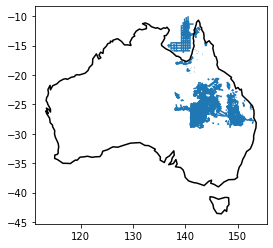

In [8]:
# plot seismic line data
fig,ax = plt.subplots()
seis_qld.plot(ax=ax)
aus.boundary.plot(ax=ax,color='black')

<AxesSubplot:>

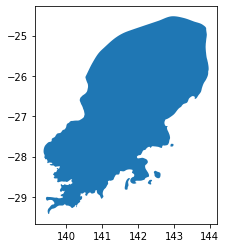

In [9]:
# load AOI shapefile and extract polygon entry
aoi_all = gpd.read_file('GBA_regions_GCS_GDA94.shp')
aoi = aoi_all[aoi_all.NAME == 'Cooper GBA region']
aoi.plot()

<AxesSubplot:>

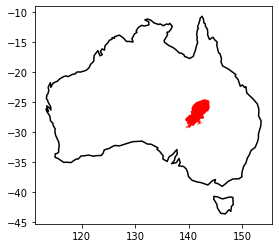

In [10]:
# plot AOI
fig,ax = plt.subplots()
aus.boundary.plot(ax=ax,color='black')
aoi.plot(ax=ax,color='red')

<AxesSubplot:>

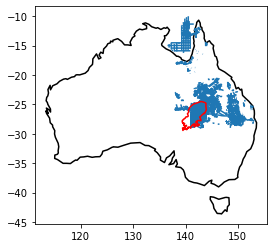

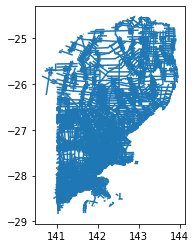

In [11]:
# plot seismic and AOI
fig,ax = plt.subplots()
aus.boundary.plot(ax=ax,color='black')
seis_qld.plot(ax=ax)
aoi.boundary.plot(ax=ax,color='red')

# Crop seismic to AOI
seisQD1 = gpd.clip(seis_qld,aoi)
seisQD1.plot()

<AxesSubplot:>

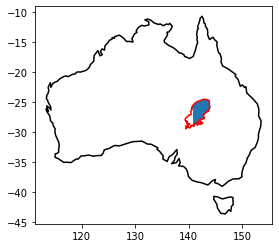

In [12]:
# plot seismic line data in AOI
fig,ax = plt.subplots()
aus.boundary.plot(ax=ax,color='black')
seisQD1.plot(ax=ax)
aoi.boundary.plot(ax=ax,color='red')

## Summarize seismic line data within AOI
A seismic survey may consist of multiple seismic lines represented by multiple line vector entries in the shapefile. The seismic survey name can be used to aggregate the geometries. 

Each entry in the seismic shapefile may contain or one or more lines as a single vector. Each entry is first separated into line vectors that may be representative of a single seismic line. Orientation of the presumed seismic line is calculated and the attributes associated with the line is aggregated for each seismic survey.

In [13]:
seisQD1.columns

Index(['SURVEY_NO', 'SURVEY_NAM', 'LINE_ID', 'LINE_PREFI', 'LINE_IDENT',
       'LINE_SUFFI', 'LINE_KEY', 'OPERATOR_C', 'OPERATOR_N', 'COMMENCE_D',
       'COMPLETION', 'SURVEY_LEN', 'MAIN_COMPA', 'REPORT_STA', 'CONTACT',
       'SHAPE_LEN', 'geometry'],
      dtype='object')

In [14]:
# get unique seismic surveys
qd1surveys = seisQD1.SURVEY_NO.unique().astype('int64')

<AxesSubplot:>

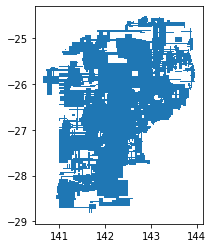

In [15]:
# Create a new geopandas dataframe for seismic survey data to be aggregated
qld = gpd.GeoDataFrame()
qld['geometry'] = None

# Gather line geometry by survey
for i,s in enumerate(seisQD1.SURVEY_NO.unique()):
    temp = seisQD1[seisQD1.SURVEY_NO == s]
    geom = temp.loc[np.setdiff1d(temp.index,temp.index[np.where(temp.geometry == None)[0]]),'geometry'].envelope.unary_union
    qld.loc[i,'geometry'] = geom
qld.plot()

In [16]:
## Collapse fields by survey 
qld['surveyNo'] = qd1surveys
nsurveys = len(qld)
qld['nlines'] = np.zeros(nsurveys)
qld['geometryR'] = np.zeros(nsurveys)*np.nan
qld['geometryS'] = np.zeros(nsurveys)*np.nan
qld['geometryO'] = np.zeros(nsurveys)*np.nan
qld['linelength'] = np.zeros(nsurveys)
qld['linekms'] = np.zeros(nsurveys)
qld['fold'] = np.zeros(nsurveys)*np.nan
qld['recordtype'] = np.ndarray(nsurveys, dtype=object)
qld['name'] = np.ndarray(nsurveys, dtype=object)
qld['province'] = np.ndarray(nsurveys, dtype=object)
qld['tenement'] = np.ndarray(nsurveys, dtype=object)
qld['operator'] = np.ndarray(nsurveys, dtype=object)
qld['contractor'] = np.ndarray(nsurveys, dtype=object)
qld['source'] = np.ndarray(nsurveys, dtype=object)
qld['recmode'] = np.ndarray(nsurveys, dtype=object)
qld['instrument'] = np.ndarray(nsurveys, dtype=object)
qld['channels'] = np.zeros(nsurveys)*np.nan
qld['groupint'] = np.ndarray(nsurveys, dtype=object)
qld['spvpint'] = np.ndarray(nsurveys, dtype=object)
qld['datebeg'] = np.ndarray(nsurveys, dtype=object)
qld['dateend'] = np.ndarray(nsurveys, dtype=object)
qld['bearing'] = np.ndarray(nsurveys, dtype=object)
qld['bearingcnt'] = np.ndarray(nsurveys, dtype=object)
qld['state'] = np.ndarray(nsurveys, dtype=object)

i=0
for s in seisQD1.SURVEY_NO.unique():
    qld.loc[i,'name'] = seisQD1[seisQD1.SURVEY_NO == qd1surveys[i]].SURVEY_NAM.unique()
    qld.loc[i,'operator'] = seisQD1[seisQD1.SURVEY_NO == qd1surveys[i]].OPERATOR_N.unique()
    qld.loc[i,'datebeg'] = seisQD1[seisQD1.SURVEY_NO == qd1surveys[i]].COMMENCE_D.unique()
    qld.loc[i,'dateend'] = seisQD1[seisQD1.SURVEY_NO == qd1surveys[i]].COMPLETION.unique()

    # Separate each vector entry to ensure individual seismic lines are properly represented
    geoms = seisQD1[seisQD1.SURVEY_NO == s].geometry
    orient = np.zeros(len(geoms))
    lengths = np.zeros(len(geoms))
    for j,lines in enumerate(geoms):
        if(type(lines) is shapely.geometry.multilinestring.MultiLineString):
            orient[j] = getBearing(list(lines[0].coords)[0],list(lines[0].coords)[-1])
            lengths[j] = lines.length
        elif(lines is None):
            print(s,'line',j,' has no geometry, skipping entry')
        else:
            orient[j] = getBearing(list(lines.coords)[0],list(lines.coords)[-1])
            lengths[j] = lines.length
    
    estimated_lines = np.where(lengths > lengths.mean())[0]
    estimated_bear = orient[estimated_lines]
    vals,cnts = np.unique(np.round(estimated_bear), return_counts=True)
    
    qld.loc[i,'nlines'] = len(estimated_lines)
    qld.loc[i,'linelength'] = np.sum(lengths)
    qld.loc[i,'linekms'] = np.sum(lengths)/1000 #km 
    qld.loc[i,'bearing'] = str(vals)
    qld.loc[i,'bearingcnt'] = str(cnts)
    qld.loc[i,'state'] = 'QLD'
    i=i+1
    
qld['years'] = pd.DatetimeIndex(qld['datebeg']).year

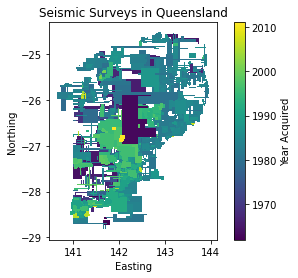

In [17]:
fig,ax = plt.subplots()
qld.plot(column='years',legend=True,ax=ax,legend_kwds={'label':"Year Acquired"})
ax.set_title("Seismic Surveys in Queensland")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.show()

### Orientation of seismic surveys
Aggregate line orientations and plot. Based on rose diagrams, surveys are 
generally aligned in two-dominant orientations. Assume that seismic surveys
orient receiver and source lines perpendicular to each other (for both 2D and 3D
surveys).
The dominant orientations for surveys are assumed to be binned as follows:
   1. north-south, east-west (0 & 180 degrees, 90 & 270 degrees)
   2. NE-SW, NW-SE (30 & 210 degrees, 120 & 300 degrees)


In [18]:
# get individual bearings
strikes = np.zeros(0)
yrs = np.zeros(0)
for i in np.arange(len(qld)):
    if(qld.loc[i,'bearing'] == '[]'):
        print('Skipping empty entry for ',i)
    else:
        dirs = np.array(qld.loc[i,'bearing'].replace('\n', '')[1:-2].split('. '), dtype='int')
        cnts = np.array(qld.loc[i,'bearingcnt'].replace('\n', '')[1:-1].split(), dtype='int')
        for j,item in enumerate(dirs):
            s = np.repeat(item,repeats=cnts[j])
            strikes = np.concatenate([strikes,s])
            y = np.repeat(qld.loc[i,'years'].astype('int'),repeats=cnts[j])
            yrs = np.concatenate([yrs,y])

# create dataframe to store bearings
bear = pd.DataFrame(np.vstack([yrs,strikes]).T, columns=['years','bearing'])
bear = bear.astype({'years':'float64','bearing':'float64'})

Skipping empty entry for  62
Skipping empty entry for  103
Skipping empty entry for  120
Skipping empty entry for  144
Skipping empty entry for  158


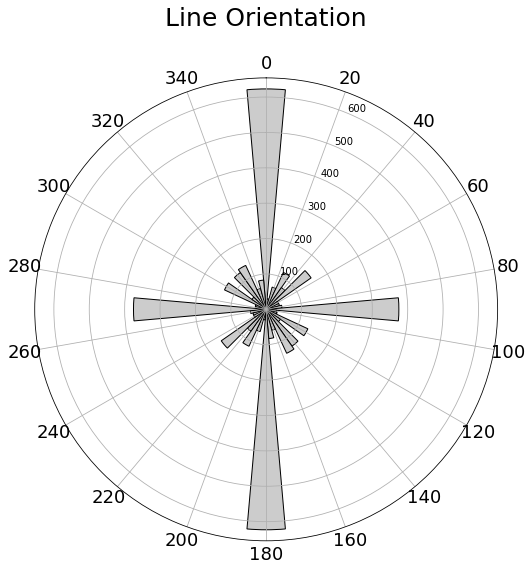

In [19]:
polplot(bear.bearing.values,title='Line Orientation',save=False)

### Categorize seismic survey dimension based on bearing
The plot shows the orientations of all seismic lines in the AOI. The dominate NS and EW directions are likely the 3D surveys. The off-cardinal direction entries are likely the 2D surveys that tend to be oriented perpendicular to the geologic feature of interest.

The surveys are categorized according to this assumption.

In [20]:
qld['dimension'] = np.ndarray(nsurveys, dtype=object)

for i in np.arange(len(qld)):
    if(qld.loc[i,'bearing'] == '[]'):
        print('Skipping empty entry for ',i)
    else:
        dirs = np.array(qld.loc[i,'bearing'].replace('\n', '')[1:-2].split('. '), dtype='int')
        ibear = np.mean(dirs)
        
        if(ibear >= 340 or ibear <=15):
            group = '3D'
        elif(ibear > 15 and ibear <60):
            group = '2D'
        elif(ibear >= 60 and ibear <100):
            group = '3D'
        elif(ibear >=100 and ibear <160):
            group = '2D'
        elif(ibear >= 160 and ibear < 200):
            group = '3D'
        elif(ibear >=200 and ibear < 260):
            group = '2D'
        elif(ibear >=260 and ibear < 280):
            group = '3D'
        elif(ibear >=280 and ibear < 340):
            group = '2D'
        
        qld.loc[i,'dimension'] = group

Skipping empty entry for  62
Skipping empty entry for  103
Skipping empty entry for  120
Skipping empty entry for  144
Skipping empty entry for  158


### Calculate probability

✔️ **Infer and calculate historical probability of seismic survey dimension (2D or 3D) by year**

Text(0.5, 1.0, 'Probability of 2D or 3D')

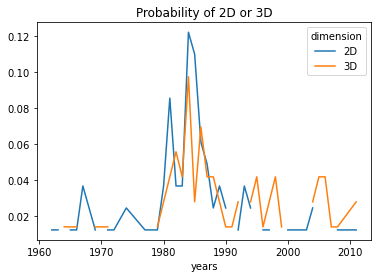

In [21]:
# Probability of 2D or 3D
probs_dimension = qld.groupby('dimension').size().div(len(qld))

# Probability of 2D or 3D given the year
probs_dimyear = qld.groupby(['years', 'dimension']).size().div(len(qld)).div(probs_dimension, axis=0, level='dimension')

dimension = probs_dimyear.reset_index()
dimension.rename(columns={0:"probability"}, inplace=True)

pivot_dim = dimension.pivot(index='years', columns='dimension', values='probability')
pivot_dim.plot()
plt.title('Probability of 2D or 3D')

# Clean up directory

Remove downloaded files from directory

In [22]:
mydir = os.getcwd()
for mdir, sdir, filenames in os.walk(mydir):
    # Find the files that matches the given patterm
    for filename in fnmatch.filter(filenames, 'GBA*'):
        try:
            os.remove(os.path.join(mydir, filename))
        except OSError:
            print("Error while deleting file: "+filename)

In [23]:
seisdir = "QLD_DNRM_Seismic_survey_2D_-_Queensland"
for mdir, sdir, filenames in os.walk(os.path.join(mydir,seisdir)):
    for filename in fnmatch.filter(filenames, 'Seismic*'):
        try:
            os.remove(os.path.join(mydir, seisdir, filename))
        except OSError:
            print("Error while deleting file: "+filename)

In [24]:
try:
    os.rmdir(seisdir)
except OSError:
    print("Error while deleting directory: "+seisdir)